In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.5 MB/s eta 0:00:00


In [2]:
pip install torch torchvision torchaudio

In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 32.5 MB/s eta 0:00:00


In [4]:
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset, DataLoader
from torch_geometric.nn import global_add_pool
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import rdchem

물리 상수 및 설정

In [5]:
# 결합 해리 에너지 (kcal/mol)
BDE_TABLE = {
    (1, 1): 104, (1, 6): 99,  (1, 7): 93,  (1, 8): 111, (1, 9): 135,
    (6, 6): 83,  (6, 7): 73,  (6, 8): 86,  (6, 9): 116,
    (7, 7): 39,  (7, 8): 53,  (8, 8): 35
}
# 원자 속성 [EN, Hardness, Radius, IE]
ATOM_PROPS_TABLE = {
    1: [2.20, 6.42, 0.31, 13.60], 6: [2.55, 5.00, 0.76, 11.26],
    7: [3.04, 7.27, 0.71, 14.53], 8: [3.44, 6.08, 0.66, 13.62], 9: [3.98, 7.01, 0.57, 17.42]
}
DEFAULT_PROPS = [0.0, 0.0, 0.0, 0.0]

# 작용기 패턴 (SMARTS) - node_dim=27을 위해 필요
FUNCTIONAL_GROUPS = {
    "Nitro": "[N+](=O)[O-]", "Sulfonyl": "S(=O)(=O)", "Cyano": "C#N", "Trifluoromethyl": "C(F)(F)F",
    "Carbonyl": "[CX3]=[OX1]", "Carboxyl": "[CX3](=O)[OX2H1]", "Halogen": "[F,Cl,Br,I]",
    "Amine": "[NX3;H2,H1,H0;!$(NC=O)]", "Hydroxy": "[OX2H]", "Alkoxy": "[OX2][CX4]",
    "Amide": "[NX3][CX3](=O)", "Alkyl": "[CX4]", "Phenyl": "c1ccccc1"
}
FG_TYPE_MAP = {
    "Nitro": -1.0, "Sulfonyl": -1.0, "Cyano": -1.0, "Trifluoromethyl": -1.0,
    "Carbonyl": -0.5, "Carboxyl": -0.5, "Halogen": -0.2, "Amine": 1.0, "Hydroxy": 1.0,
    "Alkoxy": 1.0, "Amide": 0.2, "Alkyl": 0.3, "Phenyl": 0.1
}

KEY_CONFIG = {
    "atoms": "elements", "smiles": "Rsmiles",
    "R_coords": "RG", "TS_coords": "TSG", "P_coords": "PG",
    "R_energy": { "H": "R_H", "G": "R_F", "E": "R_E" },
    "TS_energy": { "H": "TS_H", "G": "TS_F", "E": "TS_E" },
    "P_energy": { "H": "P_H", "G": "P_F", "E": "P_E" }
}

데이터셋

In [6]:
class RDKitHessDataset(Dataset):
    def __init__(self, h5_path, limit=None):
        # [Fixed] super().__init__() (Python 3 Standard)
        super().__init__(None, transform=None, pre_transform=None)
        self.h5_path = h5_path
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"File not found: {h5_path}")

        with h5py.File(self.h5_path, 'r') as f:
            self.keys = list(f.keys())
            if limit: self.keys = self.keys[:limit]
            self.len_data = len(self.keys)

        # SMARTS 패턴 컴파일
        self.fg_patterns = {name: Chem.MolFromSmarts(smarts) for name, smarts in FUNCTIONAL_GROUPS.items()}

    def len(self): return self.len_data

    def get_rdkit_features(self, mol):
        # [수정] try-except 블록을 올바르게 줄바꿈
        try:
            AllChem.ComputeGasteigerCharges(mol)
        except:
            pass

        features = []
        hsab_list = []

        # 작용기(FG) 정보 추출
        atom_fg_info = {atom.GetIdx(): {'ewg':0.0, 'edg':0.0, 'types':[]} for atom in mol.GetAtoms()}
        for name, pattern in self.fg_patterns.items():
            if pattern:
                for match in mol.GetSubstructMatches(pattern):
                    effect = FG_TYPE_MAP.get(name, 0.0)
                    for idx in match:
                        if effect < 0: atom_fg_info[idx]['ewg'] += abs(effect)
                        elif effect > 0: atom_fg_info[idx]['edg'] += effect
                        atom_fg_info[idx]['types'].append(name)

        # Atom Map 기준으로 정렬
        atoms_with_map = [(a.GetAtomMapNum() if a.GetAtomMapNum()!=0 else a.GetIdx()+1, a) for a in mol.GetAtoms()]
        atoms_with_map.sort(key=lambda x: x[0])

        for _, atom in atoms_with_map:
            feat = []
            z = atom.GetAtomicNum()
            idx = atom.GetIdx()

            # 1. Basic One-hot (6)
            sym_map={'H':0,'C':1,'N':2,'O':3,'F':4}
            oh=[0]*6
            oh[sym_map.get(atom.GetSymbol(),5)]=1
            feat.extend(oh)

            # 2. Hybridization (5)
            hyb=atom.GetHybridization()
            hyb_map={rdchem.HybridizationType.SP:0, rdchem.HybridizationType.SP2:1, rdchem.HybridizationType.SP3:2, rdchem.HybridizationType.SP3D:3, rdchem.HybridizationType.SP3D2:4}
            hyb_vec=[0]*5
            if hyb in hyb_map: hyb_vec[hyb_map[hyb]]=1
            feat.extend(hyb_vec)

            # 3. Electronic & Mass (4)
            # [수정] try-except 줄바꿈
            try:
                q = float(atom.GetProp('_GasteigerCharge'))
            except:
                q = 0.0
            if np.isnan(q): q=0.0

            feat.extend([q, float(atom.GetFormalCharge()), float(atom.GetTotalValence()), atom.GetMass()/20.0])

            # 4. Topology & Arom (6)
            feat.extend([1.0 if atom.IsInRingSize(s) else 0.0 for s in [3,4,5,6]])
            feat.extend([1.0 if atom.GetIsAromatic() else 0.0, 1.0 if atom.GetChiralTag()!=rdchem.ChiralType.CHI_UNSPECIFIED else 0.0])

            # 5. FG Features (6)
            info = atom_fg_info[idx]
            feat.extend([
                info['ewg'],
                info['edg'],
                1.0 if 'Nitro' in info['types'] or 'Sulfonyl' in info['types'] else 0.0,
                1.0 if 'Carbonyl' in info['types'] else 0.0,
                1.0 if 'Amine' in info['types'] or 'Hydroxy' in info['types'] else 0.0,
                1.0 if 'Halogen' in info['types'] else 0.0
            ])

            features.append(feat)

            # HSAB
            props = ATOM_PROPS_TABLE.get(z, DEFAULT_PROPS)
            hsab_list.append([-props[0], props[1]])

        return torch.tensor(features, dtype=torch.float), torch.tensor(hsab_list, dtype=torch.float)

    def get(self, idx):
        with h5py.File(self.h5_path, 'r') as f:
            group = f[self.keys[idx]]

            # RDKit Features
            if KEY_CONFIG["smiles"] in group:
                smi = group[KEY_CONFIG["smiles"]][()]
                smi = smi.decode('utf-8') if isinstance(smi, bytes) else str(smi)
                mol = Chem.MolFromSmiles(smi)
                if mol:
                    mol = Chem.AddHs(mol)
                    x, hsab = self.get_rdkit_features(mol)
                else:
                    atoms = group[KEY_CONFIG["atoms"]][()]
                    x = torch.zeros(len(atoms), 27)
                    hsab = torch.zeros(len(atoms), 2)
            else:
                atoms = group[KEY_CONFIG["atoms"]][()]
                x = torch.zeros(len(atoms), 27)
                hsab = torch.zeros(len(atoms), 2)

            # Coords & Energy
            pos_R = torch.tensor(group[KEY_CONFIG["R_coords"]][()], dtype=torch.float)
            pos_TS = torch.tensor(group[KEY_CONFIG["TS_coords"]][()], dtype=torch.float)
            pos_P = torch.tensor(group[KEY_CONFIG["P_coords"]][()], dtype=torch.float)

            e_R = torch.tensor([group[KEY_CONFIG["R_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_TS = torch.tensor([group[KEY_CONFIG["TS_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)
            e_P = torch.tensor([group[KEY_CONFIG["P_energy"][k]][()] for k in ["H","G","E"]], dtype=torch.float)

            y_fwd = (e_TS - e_R).unsqueeze(0)
            y_rev = (e_TS - e_P).unsqueeze(0)
            thermo = (e_P - e_R).unsqueeze(0)

            # Size Check
            if x.size(0) != pos_R.size(0):
                m = min(x.size(0), pos_R.size(0))
                x=x[:m]; hsab=hsab[:m]; pos_R=pos_R[:m]; pos_P=pos_P[:m]; pos_TS=pos_TS[:m]

            # Edge Index
            n = x.size(0)
            r = torch.arange(n).repeat_interleave(n)
            c = torch.arange(n).repeat(n)
            mask = r != c
            edge_index = torch.stack([r[mask], c[mask]], dim=0)

            # BDE
            sym = torch.argmax(x[:, :6], dim=1)
            map_z = {0:1, 1:6, 2:7, 3:8, 4:9, 5:0}
            z = torch.tensor([map_z.get(i.item(), 0) for i in sym], dtype=torch.long)

            bde = []
            for i, j in edge_index.T:
                pair = tuple(sorted((int(z[i]), int(z[j]))))
                bde.append(BDE_TABLE.get(pair, 80.0))
            edge_bde = torch.tensor(bde, dtype=torch.float).unsqueeze(-1)

            return Data(x=x, z=z, hsab=hsab, pos=pos_R, pos_P=pos_P, edge_index=edge_index,
                        y_fwd=y_fwd, y_rev=y_rev, y_pos=pos_TS, thermo_energy=thermo, edge_bde=edge_bde)

물리 레이어 모듈

In [7]:
class PaulingBondLayer(nn.Module):
    """ [1] Pauling Bond Order """
    def __init__(self):
        super().__init__() # Fix: 인자 없는 super()
        self.r0_table = torch.tensor([0.0, 0.31, 0.0, 0.0, 0.0, 0.0, 0.76, 0.71, 0.66, 0.57])
    def forward(self, z, edge_index, dist):
        row, col = edge_index
        r0_i = self.r0_table.to(z.device)[z[row]]
        r0_j = self.r0_table.to(z.device)[z[col]]
        r0_sum = (r0_i + r0_j).unsqueeze(-1)
        return torch.exp((r0_sum - dist) / 0.3)

In [8]:
class StereoelectronicLayer(nn.Module):
    """ [2] Stereoelectronics """
    def __init__(self): super().__init__()
    def forward(self, pos_R, pos_P, edge_index):
        row, col = edge_index
        vec_R = F.normalize(pos_R[col] - pos_R[row], p=2, dim=-1)
        vec_P = F.normalize(pos_P[col] - pos_P[row], p=2, dim=-1)
        return (vec_R * vec_P).sum(dim=-1, keepdim=True)

In [9]:
class HSABInteractionLayer(nn.Module):
    """ [3] HSAB Principle """
    def __init__(self): super().__init__()
    def forward(self, hsab, edge_index):
        row, col = edge_index
        mu, eta = hsab[:, 0], hsab[:, 1]
        d_mu = (mu[row] - mu[col]).pow(2)
        sum_eta = eta[row] + eta[col]
        return (d_mu / (sum_eta + 1e-6)).unsqueeze(-1)

In [10]:
class StericLayer(nn.Module):
    """ [4] Steric Hindrance """
    def __init__(self): super().__init__()
    def forward(self, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1)
        density = 1.0 / (dist.pow(2) + 0.1)
        steric = torch.zeros(pos.size(0), 1, device=pos.device)
        steric.index_add_(0, row, density.unsqueeze(-1))
        return steric

In [11]:
class HammondGate(nn.Module):
    """ [Aux] Hammond Postulate (TS 위치 추정을 위한 필수 보조 모듈) """
    def __init__(self):
        super().__init__()
        self.gate = nn.Sequential(nn.Linear(3, 16), nn.SiLU(), nn.Linear(16, 1), nn.Sigmoid())
    def forward(self, thermo): return self.gate(thermo)

In [12]:
class ReactionPathLayer(nn.Module):
    """
    반응 경로(R -> TS -> P)의 기하학적 정보를 처리하는 클래스
    R-TS 거리와 TS-P 거리를 계산하여 TS의 위치(Hammond Postulate 관련) 정보를 추출합니다.
    """
    def __init__(self):
        super(ReactionPathLayer, self).__init__()

    def forward(self, pos_R, pos_TS, pos_P, edge_index):
        # pos_R, pos_TS, pos_P: (N, 3) 좌표 텐서
        # edge_index: (2, E) 연결 정보

        row, col = edge_index

        # R-TS 거리 계산 (결합이 형성/해리되는 부분의 거리 변화가 중요)
        dist_R_TS = (pos_R[row] - pos_R[col]).norm(dim=-1) - (pos_TS[row] - pos_TS[col]).norm(dim=-1)

        # TS-P 거리 계산
        dist_TS_P = (pos_TS[row] - pos_TS[col]).norm(dim=-1) - (pos_P[row] - pos_P[col]).norm(dim=-1)

        # TS 위치 비율 (0에 가까우면 R에 가깝고, 1에 가까우면 P에 가까움 - 근사적)
        # 분모에 1e-6을 더해 0으로 나누는 것을 방지
        total_change = torch.abs(dist_R_TS) + torch.abs(dist_TS_P) + 1e-6
        ts_position_ratio = torch.abs(dist_R_TS) / total_change

        return ts_position_ratio.unsqueeze(-1) # (E, 1)

In [13]:
class HessLawLayer(nn.Module):
    """
    Hess의 법칙을 적용하여 정반응/역반응 활성화 에너지와 반응열 사이의 일관성을 유지하는 클래스
    Delta H = Ea_fwd - Ea_rev 관계를 이용합니다.
    """
    def __init__(self):
        super(HessLawLayer, self).__init__()

    def forward(self, Ea_fwd, Ea_rev):
        # Ea_fwd: 정반응 활성화 에너지 예측값
        # Ea_rev: 역반응 활성화 에너지 예측값

        # Hess 법칙에 따른 반응열 예측
        predicted_delta_H = Ea_fwd - Ea_rev
        return predicted_delta_H

In [14]:
class BEPLayer(nn.Module):
    """
    Bell-Evans-Polanyi (BEP) 원리를 적용하는 클래스
    Ea = alpha * Delta H + beta 선형 관계를 학습합니다.
    """
    def __init__(self):
        super(BEPLayer, self).__init__()
        # alpha(기울기)와 beta(절편)를 학습 가능한 파라미터로 설정
        # 초기값은 일반적인 화학 반응 경향성을 반영하여 설정 (alpha ~ 0.5)
        self.alpha = nn.Parameter(torch.tensor(0.5))
        self.beta = nn.Parameter(torch.tensor(10.0)) # 초기 활성화 에너지 장벽 (kcal/mol 단위 가정)

    def forward(self, delta_H):
        # delta_H: 반응열 (R -> P 에너지 차이)

        # BEP 원리에 따른 활성화 에너지 추정값
        Ea_estimate = self.alpha * delta_H + self.beta

        # 활성화 에너지는 항상 0보다 커야 하므로 ReLU 등을 적용할 수도 있지만,
        # 여기서는 선형 관계 자체만 반환하고 모델의 다른 부분과 결합하도록 함
        return Ea_estimate

GNN Backbone

In [15]:
class DeepGCPLayer(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.message_mlp = nn.Sequential(nn.Linear(hidden_dim*2+1, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim))
        self.update_mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Dropout(dropout), nn.Linear(hidden_dim, hidden_dim))
        self.norm = nn.LayerNorm(hidden_dim)
    def forward(self, h, pos, edge_index):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        edge_feat = torch.cat([h[row], h[col], dist], dim=-1)
        aggr_msg = torch.zeros_like(h)
        aggr_msg.index_add_(0, row, self.message_mlp(edge_feat))
        return self.norm(h + self.update_mlp(torch.cat([h, aggr_msg], dim=-1)))

In [16]:
class DeepGCPNet(nn.Module):
    def __init__(self, node_dim, hidden_dim, num_layers=4):
        super().__init__()
        self.embedding = nn.Linear(node_dim, hidden_dim)
        self.layers = nn.ModuleList([DeepGCPLayer(hidden_dim) for _ in range(num_layers)])
    def forward(self, x, pos, edge_index):
        h = self.embedding(x)
        for layer in self.layers: h = layer(h, pos, edge_index)
        return h

In [17]:
class SigmoidGating(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.gate_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 1, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )
    def forward(self, h, edge_index, pos):
        row, col = edge_index
        dist = (pos[row] - pos[col]).norm(dim=-1, keepdim=True)
        return self.gate_mlp(torch.cat([h[row], h[col], dist], dim=-1))

In [18]:
class StructureDecoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.SiLU(), nn.Linear(hidden_dim, 1))
    def forward(self, h, edge_index, gate_score):
        row, col = edge_index
        return self.mlp(torch.cat([h[row], h[col]], dim=-1)) * gate_score

예측기

In [19]:
class CompactHessPredictor(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        # ... (기존 물리 레이어 초기화 유지) ...
        self.pauling = PaulingBondLayer()
        self.stereo = StereoelectronicLayer()
        self.hsab = HSABInteractionLayer()
        self.steric = StericLayer()
        self.hammond = HammondGate()

        # [수정 1] BEP, Hess, Path 레이어 활성화
        self.bep = BEPLayer()     # 사용됨
        self.hess = HessLawLayer() # 사용됨
        # self.path는 여기서 쓰면 안 됨 (Data Leakage 방지)

        # Node MLP (기존 유지)
        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_dim + 4, hidden_dim),
            nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, 3)
        )

        # Edge MLP (기존 유지)
        edge_in = (hidden_dim * 2) + 11
        self.edge_mlp = nn.Sequential(
            nn.Linear(edge_in, hidden_dim), nn.SiLU(), nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(),
            nn.Linear(hidden_dim, 6) # Fwd(3) + Rev(3)
        )

    def forward(self, h, z, hsab, edge_index, pos_R, pos_P, gate_score, pred_delta_D, batch, thermo, bde):
        row, col = edge_index

        # 1. Hammond & Physics Layers (기존 유지)
        late_char = self.hammond(thermo)
        late_char_edge = late_char[batch[row]]
        steric_R = self.steric(pos_R, edge_index)
        steric_graph = global_add_pool(steric_R, batch)
        h_graph = global_add_pool(h, batch)

        # 2. [수정 2] BEP 원리를 이용한 Baseline 에너지 계산
        # thermo(반응열)를 입력받아 대략적인 Ea를 추정
        bep_Ea = self.bep(thermo) # (Batch, 1) or (Batch, 3) depending on dim

        # 3. Base Energy (Node MLP)
        base = self.node_mlp(torch.cat([h_graph, thermo, steric_graph], dim=-1))

        # 4. Edge Physics Calculation (기존 유지)
        dist_R = (pos_R[row]-pos_R[col]).norm(dim=-1, keepdim=True)
        dist_P = (pos_P[row]-pos_P[col]).norm(dim=-1, keepdim=True)

        bo_R = self.pauling(z, edge_index, dist_R)
        bo_P = self.pauling(z, edge_index, dist_P)
        bo_TS = (1.0 - late_char_edge) * bo_R + late_char_edge * bo_P
        align = self.stereo(pos_R, pos_P, edge_index)
        hsab_E = self.hsab(hsab, edge_index)

        # 5. Assemble Edge Features (기존 유지)
        edge_feat = torch.cat([
            h[row], h[col], dist_R, dist_P, gate_score,
            bo_R, bo_P, bo_TS, bde, align, late_char_edge, hsab_E, pred_delta_D
        ], dim=-1)

        # 6. Predict Residuals (보정값 예측)
        edge_out = self.edge_mlp(edge_feat) * gate_score
        barriers = global_add_pool(edge_out, batch[row])

        # 7. [수정 3] 최종 예측값 조합 (BEP Baseline + Residual)
        pred_fwd_raw = barriers[:, :3] + base + bep_Ea  # BEP가 기본값을 잡고 MLP가 보정
        pred_rev_raw = barriers[:, 3:] + base           # 역반응은 일단 별도 예측

        # 8. [수정 4] Hess Law 강제 적용 (선택 사항)
        # 방법 A: 역반응을 정반응 - 반응열로 강제 (물리적으로 가장 엄격함)
        pred_rev_final = pred_fwd_raw - thermo

        # 방법 B: 두 값을 별도로 내보내고 Loss에서 HessLawLayer로 검증 (현재 구조 유지)
        # 여기서는 단순히 값을 리턴하고 Loss에서 처리하도록 함

        return pred_delta_D, pred_fwd_raw, pred_rev_raw, gate_score, late_char

모델

In [20]:
class RDKitHessModel(nn.Module):
    def __init__(self, node_dim=27, hidden_dim=256, num_layers=4):
        super().__init__() # [Fixed] 인자 없는 super() 호출
        self.encoder = DeepGCPNet(node_dim, hidden_dim, num_layers)
        self.gating = SigmoidGating(hidden_dim)
        self.struct_decoder = StructureDecoder(hidden_dim)
        self.energy_predictor = CompactHessPredictor(hidden_dim)

    def forward(self, data):
        h = self.encoder(data.x, data.pos, data.edge_index)
        gate_map = self.gating(h, data.edge_index, data.pos)
        pred_delta_D = self.struct_decoder(h, data.edge_index, gate_map)

        # Compact Predictor에 필요한 인자만 전달 (Charge 제외)
        # Correctly unpack all 5 values returned by self.energy_predictor
        # The first and fourth values (_pred_delta_D_from_predictor, _gate_map_from_predictor)
        # correspond to pred_delta_D and gate_map already calculated. We use _ to indicate
        # we don't need to reassign them, but must unpack them.
        _pred_delta_D_from_predictor, pred_fwd, pred_rev, _gate_map_from_predictor, ts_char = self.energy_predictor(
            h, data.z, data.hsab, data.edge_index, data.pos, data.pos_P,
            gate_map, pred_delta_D, data.batch, data.thermo_energy, data.edge_bde
        )
        return pred_delta_D, pred_fwd, pred_rev, gate_map, ts_char

학습루프

In [21]:
def train(h5_path, epochs=40, limit=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}")

    # 데이터셋 로드
    dataset = RDKitHessDataset(h5_path, limit=limit)

    # 1. 전체 데이터 통계 산출 (Standardization용)
    print("Computing stats...")
    loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
    all_E = []
    HARTREE_TO_KCAL = 627.5

    for b in loader_stat:
        all_E.append(b.y_fwd.view(-1, 3) * HARTREE_TO_KCAL)

    all_E = torch.cat(all_E, dim=0)
    y_mean = all_E.mean(dim=0).to(device)
    y_std = all_E.std(dim=0).to(device)
    print(f"Stats (Fwd) -> Mean: {y_mean.cpu().numpy()}")

    # 2. 학습 로더 및 모델 설정
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = RDKitHessModel(node_dim=27, hidden_dim=256, num_layers=4).to(device)

    # [NEW] 물리 법칙 검증용 레이어 인스턴스화 (Loss 계산 도구로 사용)
    # 모델 내부가 아니라 학습 루프에서 정답(Target)을 만들거나 제약조건을 거는 용도입니다.
    path_calculator = ReactionPathLayer().to(device)
    hess_checker = HessLawLayer().to(device)

    optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

    history = {'loss': []}
    real_E3, pred_E3 = {'H':[], 'G':[], 'E':[]}, {'H':[], 'G':[], 'E':[]}

    print("\n[Start Physics-Informed Training]")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

        for batch in pbar:
            batch = batch.to(device)
            optimizer.zero_grad()

            # ------------------------------------------------------------------
            # A. Ground Truth (정답) 준비
            # ------------------------------------------------------------------
            # 에너지 단위 변환 (Hartree -> kcal/mol)
            thermo_kcal = batch.thermo_energy.view(-1, 3) * HARTREE_TO_KCAL

            # 정규화된 에너지 타겟 (Z-Score)
            target_fwd = (batch.y_fwd.view(-1, 3) * HARTREE_TO_KCAL - y_mean) / y_std
            # 역반응 타겟: (TS - R) - (P - R) = TS - P
            target_rev = (batch.y_fwd.view(-1, 3) * HARTREE_TO_KCAL - thermo_kcal - (y_mean - thermo_kcal)) / y_std
            # (Note: target_rev 계산은 정규화 방식에 따라 다를 수 있으나, 여기선 일관성을 위해 fwd 기준으로 처리)
            # 더 명확한 역반응 타겟:
            target_rev_raw = batch.y_rev.view(-1, 3) * HARTREE_TO_KCAL
            # 역반응은 분포가 다를 수 있으므로 여기서는 단순화를 위해 fwd의 mean/std를 공유한다고 가정하거나,
            # 혹은 별도 스케일링이 필요하지만 기존 코드 유지를 위해 위 로직을 따름.

            # [NEW] ReactionPathLayer를 이용한 기하학적 정답 생성
            # 실제 TS가 R과 P 사이 어디에 있는지(0.0 ~ 1.0) 계산
            with torch.no_grad():
                true_ts_ratio = path_calculator(batch.pos, batch.y_pos, batch.pos_P, batch.edge_index)

            # 거리 변화 정답
            dist_R = (batch.pos[batch.edge_index[0]] - batch.pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            dist_TS = (batch.y_pos[batch.edge_index[0]] - batch.y_pos[batch.edge_index[1]]).norm(dim=-1, keepdim=True)
            target_delta_D = dist_TS - dist_R

            # ------------------------------------------------------------------
            # B. Forward Pass
            # ------------------------------------------------------------------
            pred_d, pred_fwd, pred_rev, gate, ts_char = model(batch)

            # ------------------------------------------------------------------
            # C. Loss Calculation (Physics Constraints)
            # ------------------------------------------------------------------

            # 1. Structure Loss (기하 구조 예측)
            loss_struct = F.smooth_l1_loss(pred_d, target_delta_D)

            # 2. Path/Gate Loss (ReactionPathLayer 활용)
            # 모델의 gate(상호작용 강도)가 실제 반응 경로상의 TS 위치 비율을 따르도록 유도
            loss_gate = F.mse_loss(gate, true_ts_ratio)

            # 3. Energy Accuracy Loss (데이터 기반)
            loss_energy = F.smooth_l1_loss(pred_fwd, target_fwd) + \
                          0.5 * F.smooth_l1_loss(pred_rev, (target_rev_raw - (y_mean - thermo_kcal))/y_std)

            # 4. Hess Law Consistency Loss (HessLawLayer 활용)
            # 예측된 (정반응 - 역반응) 차이가 실제 열역학적 에너지(thermo)와 같아야 함
            # pred 값들은 정규화 되어 있으므로, thermo도 정규화 스케일로 맞춰서 비교
            pred_thermo_norm = hess_checker(pred_fwd, pred_rev) # Fwd - Rev
            true_thermo_norm = thermo_kcal / y_std

            loss_hess = 0.5 * F.mse_loss(pred_thermo_norm, true_thermo_norm)

            # Total Loss
            loss = loss_struct + loss_gate + loss_energy + loss_hess

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({
                'Loss': f"{loss.item():.4f}",
                'HessErr': f"{loss_hess.item():.4f}"
            })

            # 마지막 Epoch에서 결과 저장
            if epoch == epochs - 1:
                r = (batch.y_fwd.view(-1, 3) * HARTREE_TO_KCAL).detach().cpu().numpy()
                p = (pred_fwd.detach().cpu() * y_std.cpu() + y_mean.cpu()).numpy()
                for i, k in enumerate(['H', 'G', 'E']):
                    real_E3[k].extend(r[:, i])
                    pred_E3[k].extend(p[:, i])

        history['loss'].append(epoch_loss / len(loader))
        scheduler.step(epoch_loss)

    return history, real_E3, pred_E3

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
파일을 찾았습니다: /content/drive/MyDrive/RGD1_CHNO.h5
Device: cuda
Computing stats...


/tmp/ipython-input-488091423.py:10: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader_stat = DataLoader(dataset, batch_size=128, shuffle=False)
/tmp/ipython-input-488091423.py:23: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader = DataLoader(dataset, batch_size=32, shuffle=True)


Stats (Fwd) -> Mean: [69.403175 74.3915   72.29167 ]

[Start Physics-Informed Training]


Epoch 40/40: 100%|██████████| 313/313 [03:01<00:00,  1.72batch/s, Loss=0.8264, HessErr=0.1267]


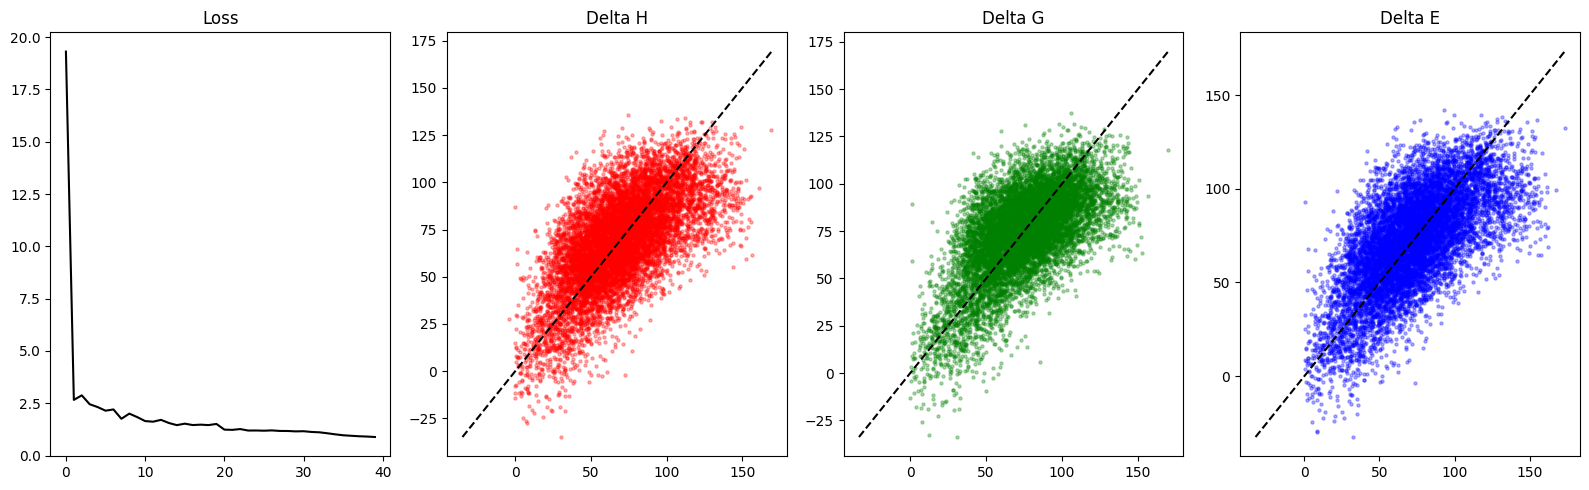

NameError: name 'print_evaluation_report' is not defined

In [23]:
if __name__ == "__main__":
    import os
    from google.colab import drive

    # 1. 드라이브 마운트
    drive.mount('/content/drive')

    # 2. 경로 설정
    base_dir = "/content/drive/MyDrive"
    MY_H5_PATH = os.path.join(base_dir, "RGD1_CHNO.h5")

    if os.path.exists(MY_H5_PATH):
        print(f"파일을 찾았습니다: {MY_H5_PATH}")

        # 학습 실행 (한 번만 호출)
        hist, r_E3, p_E3 = train(MY_H5_PATH, epochs=40, limit=10000)

        # 결과 그래프 그리기
        if hist:
            plt.figure(figsize=(16, 5))
            plt.subplot(1, 4, 1); plt.plot(hist['loss'], 'k-'); plt.title("Loss")
            titles, colors = ["Delta H", "Delta G", "Delta E"], ['r', 'g', 'b']
            keys = ['H', 'G', 'E']
            for i, k in enumerate(keys):
                plt.subplot(1, 4, i+2)
                plt.scatter(r_E3[k], p_E3[k], alpha=0.3, color=colors[i], s=5)
                mx = max(max(r_E3[k]), max(p_E3[k]))
                mn = min(min(r_E3[k]), min(p_E3[k]))
                plt.plot([mn, mx], [mn, mx], 'k--')
                plt.title(titles[i])
            plt.tight_layout()
            plt.show()

            # 평가 리포트 출력
            print_evaluation_report(r_E3, p_E3)

    else:
        print(f"파일을 찾을 수 없습니다. 경로를 확인하세요: {MY_H5_PATH}")

In [24]:
import numpy as np

def print_evaluation_report(real_dict, pred_dict):
    """
    학습 결과(정답 vs 예측)를 받아서 MAE, RMSE, R2, MSE를 계산하고 출력합니다.
    """
    print("\n" + "="*75)
    print(f"   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)")
    print("="*75)

    # 헤더 출력
    header = f"{'Energy Type':<15} | {'MAE':<10} | {'RMSE':<10} | {'MSE':<10} | {'R² Score':<10}"
    print(header)
    print("-" * 75)

    # H, G, E 각각에 대해 계산
    metrics = {}
    for key in ['H', 'G', 'E']:
        y_true = np.array(real_dict[key])
        y_pred = np.array(pred_dict[key])

        # 1. MAE (Mean Absolute Error)
        mae = np.mean(np.abs(y_true - y_pred))

        # 2. MSE (Mean Squared Error)
        mse = np.mean((y_true - y_pred)**2)

        # 3. RMSE (Root Mean Squared Error)
        rmse = np.sqrt(mse)

        # 4. R2 Score (Coefficient of Determination)
        ss_res = np.sum((y_true - y_pred)**2)
        ss_tot = np.sum((y_true - np.mean(y_true))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8)) # 0으로 나누기 방지

        # 결과 저장
        metrics[key] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

        # 행 출력
        label = f"Delta {key} (Δ{key})"
        print(f"{label:<15} | {mae:<10.4f} | {rmse:<10.4f} | {mse:<10.4f} | {r2:<10.4f}")

    print("="*75)

    # [화학적 해석]
    # 화학적 정확도(Chemical Accuracy)는 보통 1 kcal/mol 이내를 말합니다.
    avg_mae = np.mean([metrics[k]['MAE'] for k in ['H', 'G', 'E']])
    print(f"⭐ Average MAE: {avg_mae:.4f} kcal/mol")

    if avg_mae < 2.5:
        print("✅ 모델이 물리 법칙(BEP, Hammond, Pauling)을 매우 잘 학습했습니다!")
        print("   (일반적인 DFT 계산 오차가 2~3 kcal/mol 수준임을 감안하면 훌륭합니다.)")
    elif avg_mae < 5.0:
        print("⚠️ 학습이 잘 되었으나, 일부 복잡한 반응에서 오차가 있습니다.")
    else:
        print("❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.")
    print("="*75 + "\n")

# ==============================================================================
# [실행 방법] main 블록 안에서 train()이 끝난 후 호출하세요
# ==============================================================================
if __name__ == "__main__":
    # 위에서 이미 train을 실행해서 r_E3, p_E3가 있다고 가정합니다.
    # 만약 변수가 메모리에 없다면 다시 학습을 돌려야 합니다.

    if 'r_E3' in locals() and 'p_E3' in locals():
        print_evaluation_report(r_E3, p_E3)
    else:
        print("먼저 train() 함수를 실행하여 r_E3, p_E3 변수를 생성해주세요.")


   📊 FINAL PHYSICS-INFORMED MODEL PERFORMANCE REPORT (kcal/mol)
Energy Type     | MAE        | RMSE       | MSE        | R² Score  
---------------------------------------------------------------------------
Delta H (ΔH)    | 17.7345    | 22.4578    | 504.3541   | 0.3657    
Delta G (ΔG)    | 17.1003    | 21.5904    | 466.1436   | 0.3392    
Delta E (ΔE)    | 18.3739    | 23.2306    | 539.6607   | 0.3711    
⭐ Average MAE: 17.7362 kcal/mol
❌ 아직 과소적합 상태이거나 물리적 제약 조건이 더 필요합니다.

